# IBSR_23:Brain Tissue Segmentation Using Deep Learning
Author(s): **Mohammad Imran Hossain, Muhammad Zain Amin**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master Degree in Medical Imaging and Applications

# Necessary Libraries

In [14]:
# Import all the necessary libraries
import os
import cv2
import glob
import random
import tqdm 
import warnings
import pylab as pl
import scipy.misc
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt
from time import sleep

# Bias Field Correction

In [44]:
# Define the path of the train and validation dataset directory
TRAIN_DATA_PATH = Path("D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_18_BraTS_Deep_Learning/Dataset/Training_Set")
VALID_DATA_PATH = Path("D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_18_BraTS_Deep_Learning/Dataset/Validation_Set")
TEST_DATA_PATH  = Path("D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_18_BraTS_Deep_Learning/Dataset/Test_Set")

In [45]:
# Define a function to apply bias field correction
def bias_field_corrector(data_path):
    """
    Apply N4 bias field correction to all medical images in a specified directory.

    Args:
    - data_path: Path of the directory containing image data in NIfTI format.

    Returns:
    - None, but saves the corrected images in the same directory.
    """

    # Convert the data path to a Path object for easier handling
    data_path = Path(data_path)

    # Count the number of image directories in the data path
    num_images = len(list(data_path.iterdir()))

    # Initialize a progress bar to track preprocessing progress
    with tqdm(total=num_images, desc='Preprocessing Progress') as pbar:
        # Loop through each subdirectory (each representing an image)
        for image_path in data_path.iterdir():
            # Extract the image ID and define the paths for input and output images
            image_id = image_path.name
            input_image_path = image_path / f'{image_id}.nii.gz'
            output_image_path = image_path / f'{image_id}_bias.nii.gz'

            # Read the image and create a mask for the N4 bias field correction
            input_image = sitk.ReadImage(str(input_image_path))
            mask_image  = sitk.OtsuThreshold(input_image, 0, 1, 200)
            input_image = sitk.Cast(input_image, sitk.sitkFloat32)

            # Initialize and execute the N4 bias field correction filter
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            corrected_image = corrector.Execute(input_image, mask_image)

            # Save the corrected image
            sitk.WriteImage(corrected_image, str(output_image_path))

            # Update the progress bar
            pbar.update(1)


# Apply the bias field correction on training, validation, and testing image
bias_field_corrector(TRAIN_DATA_PATH)
bias_field_corrector(VALID_DATA_PATH)
bias_field_corrector(TEST_DATA_PATH)

Preprocessing Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Preprocessing Progress: 100%|██████████| 3/3 [12:20<00:00, 246.80s/it]


# Volume Dinosing 

In [77]:
def load_data(image_size, data_path):
    """
    Load image and label data from a specified directory path.
    """
    data_path = Path(data_path)
    num_images = len(list(data_path.iterdir()))
    images = np.zeros((num_images, *image_size, 1))

    with tqdm(total=num_images, desc='Loading Progress') as pbar:
        for idx, image_path in enumerate(data_path.iterdir()):
            image_id = image_path.name
            image_file = image_path / f'{image_id}_bias.nii.gz'
            
            if not image_file.exists():
                print(f"Image file {image_file} not found. Skipping.")
                continue

            image = sitk.ReadImage(str(image_file))
            image_array = sitk.GetArrayFromImage(image)
            image_array = image_array.reshape((*image_size, 1))

            images[idx] = image_array
            pbar.update(1)

    return images

# Define the image size
IMAGE_SIZE = (256, 128, 256)


# Read train and validation images and corresponding lables
bais_train_images = load_data(IMAGE_SIZE, TRAIN_DATA_PATH)
bais_valid_images = load_data(IMAGE_SIZE, VALID_DATA_PATH)

Loading Progress: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


In [87]:
def anisodiff3(stack,niter=5,kappa=15,gamma=0.001,step=(1.,1.,1.),option=1,ploton=False):

    # ...you could always diffuse each color channel independently if you
    # really want
    if stack.ndim == 4:
        warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
        stack = stack.mean(3)

    # initialize output array
    stack    = stack.astype('float32')
    stackout = stack.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(stackout)
    deltaE = deltaS.copy()
    deltaD = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    UD = deltaS.copy()
    gS = np.ones_like(stackout)
    gE = gS.copy()
    gD = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        showplane = stack.shape[0]//2

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
        ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
        ax1.set_title("Original stack (Z = %i)" %showplane)
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in range(niter):

        # calculate the diffs
        deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
        deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
        deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gD = np.exp(-(deltaD/kappa)**2.)/step[0]
            gS = np.exp(-(deltaS/kappa)**2.)/step[1]
            gE = np.exp(-(deltaE/kappa)**2.)/step[2]
        elif option == 2:
            gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
            gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

        # update matrices
        D = gD*deltaD
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'Up/North/West' by one
        # pixel. don't as questions. just do it. trust me.
        UD[:] = D
        NS[:] = S
        EW[:] = E
        UD[1:,: ,: ] -= D[:-1,:  ,:  ]
        NS[: ,1:,: ] -= S[:  ,:-1,:  ]
        EW[: ,: ,1:] -= E[:  ,:  ,:-1]

        # update the image
        stackout += gamma*(UD+NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(stackout[showplane,...].squeeze())
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return stackout



# Denoise volumes
def denoise_volumes(in_volumes):
    n_loop = in_volumes.shape[0]
    out_volumes = np.zeros_like(in_volumes)

    for i in range(n_loop):
        temp = in_volumes[i, :, :, :, 0]  
        temp = anisodiff3(temp, niter=10)
        out_volumes[i, :, :, :, 0] = temp

    return out_volumes



In [88]:
# Apply volume denoising on train, validation, and test images
denoised_train_images = denoise_volumes(train_images)
denoised_valid_images = denoise_volumes(valid_images)

In [ ]:
for k, train_dir in enumerate(TRAIN_DATA_PATH.iterdir()):
    # Extract the image ID and define the image path
    image_id = train_dir.stem 
    output_image_path = TRAIN_DATA_PATH / image_id / f'{image_id}_denoise.nii.gz' 
    
    denoise_image = denoised_train_images[k, :, :, :, 0]  # Assuming the last dimension is the channel
    denoise_image_sitk = sitk.GetImageFromArray(denoise_image)

    # Save the corrected image
    sitk.WriteImage(denoise_image_sitk, str(output_image_path))

# Visualization

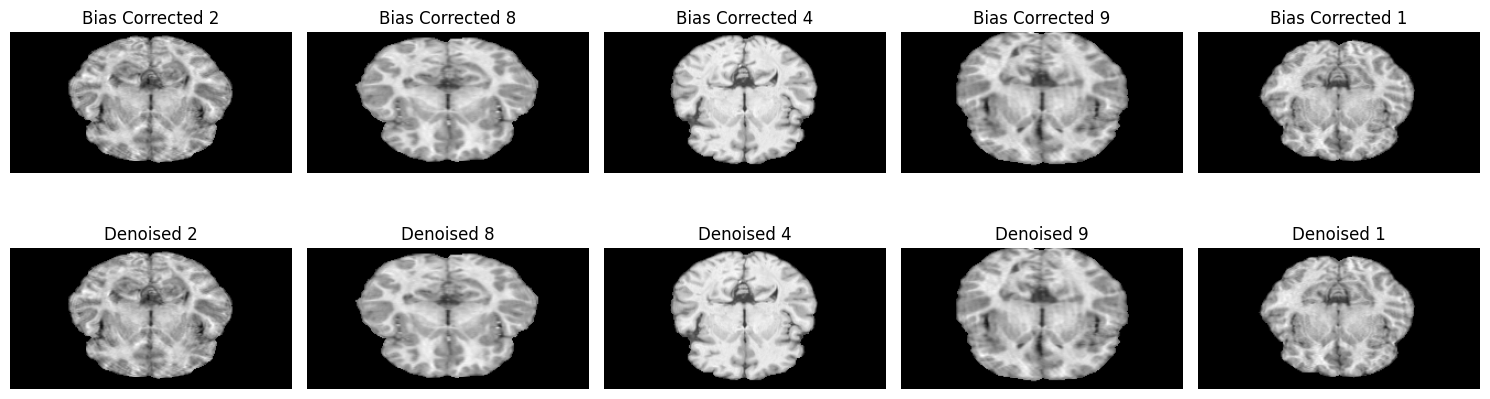

In [89]:
# Selecting 5 random indices from the range of the number of images
np.random.seed(0)  # For reproducibility
selected_indices = np.random.choice(bais_train_images.shape[0], 5, replace=False)

# Plotting the images

plt.figure(figsize=(15, 5))

# Looping through the selected indices to plot images
for i, idx in enumerate(selected_indices, 1):
    # Plot bias corrected image
    plt.subplot(2, 5, i)
    bias_image_slice = bais_train_images[idx, 128, :, :, :]  # Middle slice of the 3D image
    plt.imshow(bias_image_slice, cmap='gray')
    plt.title(f"Bias Corrected {idx}")
    plt.axis('off')

    # Plot denoised image
    plt.subplot(2, 5, i + 5)
    denoised_image_slice = denoised_train_images[idx, 128, :, :, :]  # Middle slice of the 3D image
    plt.imshow(denoised_image_slice, cmap='gray')
    plt.title(f"Denoised {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

